***An Object-oriented Python optimizer used for linac optimization together with ASTRA and IMPACT-T***

----
# Definition of the optimization problem

\begin{equation}
Min\>f(x),\>w.r.t.\>x\>
\end{equation}
\begin{equation}
s.t.\>g_i(x)<=0,\>i = 1, ..., m
\end{equation}
\begin{equation}
x_{j,lower} <= x_j <= x_{j, upper},\>j=1,2,...,n
\end{equation}

where:
- $f(x)$ is a nonlinear function;
- $g_i(x)$ is a group of linear or nonlinear functions;
- $x_j$ is the vector of design variables;
- $m$ is the number of constraints.
- $n$ is the number of design variables;

----
# System requirements:

- Linux (Ubuntu 14.04, 16.04)
- Python2 > 2.7.6
- [NumPy](http://www.numpy.org/), [Pandas](http://pandas.pydata.org/), [Scipy](https://www.scipy.org/scipylib/index.html)
- [matplotlib](http://matplotlib.org/)(only for visualization)
- [pyOpt](http://www.pyopt.org/)
- [ASTRA](http://www.desy.de/~mpyflo/)
- [IMPACT-T](http://portal.nersc.gov/project/m669/IMPACT-T/)

**Note**
- Set your system environment, **export PYTHONPATH=[your/path/for/LinacOpt/]**.
- Do not use very deep directory to run the simulation. Otherwise the name of the output file may be truncated! (This seems to be a problem with FORTRAN)

----
# Modified pyOpt (not mandatory)
**alpso.py** - Location in the original package: _pyopt/pyOpt/pyALPSO/alpso.py_

The new file will let you know why the optimization converges and print out the value of the augmented Lagrangian term.

----
# Optimizers

Global optimizers: [ALPSO](http://www.pyopt.org/reference/optimizers.alpso.html#module-pyALPSO) and [NSGA2](http://www.pyopt.org/reference/optimizers.nsga2.html#module-pyNSGA2)

Local search optimizers: [SDPEN](http://www.pyopt.org/reference/optimizers.sdpen.html#module-pySDPEN)

_Tips for ALPSO optimizer:_
- Convergence condition:
```
    if (abs(global_distance[0]-global_distance[stopIters-1]) <= \
      dtol*abs(global_distance[stopIters-1]) and \
      abs(global_L[0]-global_L[stopIters-1]) <= \
      rtol*abs(global_L[stopIters-1]) or \
      abs(global_L[0]-global_L[stopIters-1]) <= atol):
      stop_criteria_flag = 1
```
    If the objective is a small number, one must change 'atol' otherwise the optimization will stop prematurely.

- 'dynInnerIter' must be set to 1 in order to make minInnerIter take effect!

----
# Examples

  Three examples are included in the current release: astra_basic, astra_advanced, impact_basic. For advanced setups please refer to examples/astra_advanced.py

## Steps for running a simple optimization.

### Step 0: Prepare the input file template

Replace the to-be-optimized value in the input template file with `<name>`.
```
    File_Bfield(1) = 'sole1.dat', S_pos(1) = 0.144
    S_smooth(1) = 5  
    MaxB(1) = <hc_sole_b>
```

### Step 1: Assign system path and import modules

In [1]:
import sys
import os
sys.path.append(os.path.expanduser('~') + "/myscripts/linac_opt/")

from linac_opt import LinacOpt

### Step 2: Instantiate the optimization

In [2]:
opt_test = LinacOpt(path_name='examples/astra_basic',
                    input_file='injector.in',
                    input_template='injector.in.000',
                    particle_type='astra',
                    prob_name='opt_test')

### Step 3: Set up the optimizer

In [3]:
opt_test.set_optimizer('sdpen')
opt_test.optimizer.setOption('alfa_stop', 1e-2)
opt_test.optimizer.setOption('iprint', 0)
opt_test.optimizer.setOption('nf_max', 5000)

### Step 4: Set fit-points

In [4]:
opt_test.fit_points.set_point('out', 'injector.0600.001')

### Step 5: Set objective

In [5]:
def f1(fits):
    return fits.out.emitx*1.e6
opt_test.opt_prob.set_obj('emitx_um', f1)

### Step 6: Set constraint

In [6]:
def g1(fits):
    return fits.out.n0
opt_test.opt_prob.set_con('npar', g1, equal=500)

### Step 7: Set variables


In [7]:
opt_test.opt_prob.set_var('laser_spot', value=0.2, lower=0.1, upper=0.5)
opt_test.opt_prob.set_var('main_sole_b', value=0.0, lower=0.0, upper=0.4)
opt_test.opt_prob.set_var('tws1_sole_b', value=0.0, lower=0.0, upper=0.1)
opt_test.opt_prob.set_var('tws2_sole_b', value=0.0, lower=0.0, upper=0.1)

### Step 8: Run the optimization


In [8]:
opt_test.solve('astra')

File removed: opt_test.log.000
File removed: opt_test.sol.000
File removed: opt_test.sol.000.pkl

********************************************************************************
Start solving the following problem with pyOpt.SDPEN on 
astra /home/jun/myscripts/linac_opt/examples/astra_basic/injector.in
********************************************************************************

Optimization Problem -- opt_test-2017-02-03-01-42-05

Objectives:
  Name                Value        Optimum      Function        
  emitx_um             0.0000e+00  -1.0000e+21  f1              

Constraints:
  Name                Value        Bound                                           
  npar                 0.0000e+00  5.0000e+02 - 0.0000e+00 <= g1() <= 5.0000e+02 + 0.0000e+00

Variables (c - continuous, i - integer, d - discrete):
  Name                Type    Value        Lower Bound  Upper Bound
  laser_spot          c        2.0000e-01   1.0000e-01   5.0000e-01
  main_sole_b         c        0.

----
# Output

**General output:**
- prob_name.log.???: History of the optimization. ??? is the No. of step.
- prob_name.sol.???: Summary of the solution.
- prob_name.sol.???.pkl: Pickle file used for starting from a intermediate step.
- input_file: The input file will be filled with the optimized parameters.

**Output from specific optimizers:**
- ALPSO: ALPSO_print.out
- SDPEN: SDPEN.out.???

----
# Visualization

In [9]:
from beam_plots import PhaseSpacePlot

# Instantiate a PhaseSpacePlot object
p1 = PhaseSpacePlot('injector.0600.001', 'astra')

## Print the parameters

In [10]:
print p1

n                   charge (C)          p                   I_peak (A)      
      5.0000e+02          2.0000e-11          1.8954e+02          3.1806e+00

emitx (m)           emity (m)           Sx (m)              Sy (m)          
      1.2336e-07          1.2643e-07          8.3862e-05          8.4169e-05

betax (m)           betay (m)           alphax              alphay          
      1.0743e+01          1.0557e+01         -1.3972e+01         -1.3705e+01

St (m)              Sdelta              chirp (1/m)         Ct (s)          
      2.3462e-12          1.3686e-03          4.4455e-01          2.3161e-24

emitx_slice (m)     emity_slice         Sdelta_slice        St_slice        
      9.7211e-08          1.0203e-07          3.6989e-05          1.7219e-13

Cx (m)              Cy (m)              Cxp (rad)           Cyp (rad)       
      1.9498e-07         -1.7700e-07          9.7003e-08         -5.2039e-08

emitx_tr (m)        emity_tr (m)        Sdelta_un       
      1.2408e

## Phase-space plot

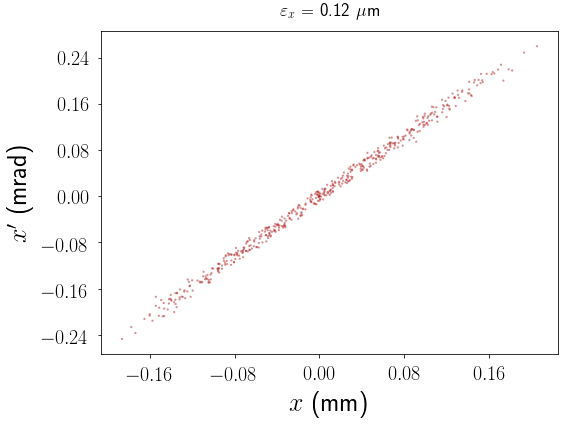

In [11]:
p1.plot('x', 'xp', density_plot=False, marker_color='firebrick', marker_size=5, alpha=0.5)

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


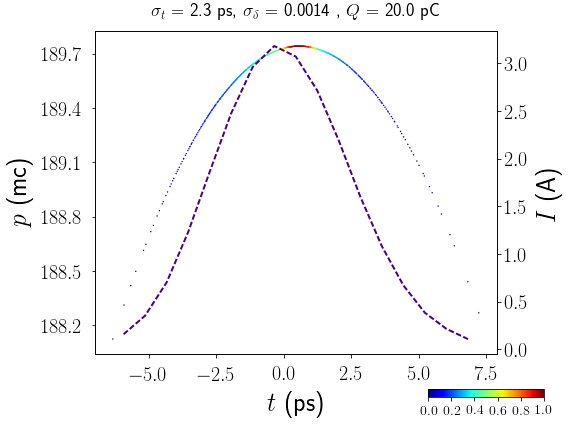

In [12]:
p1.plot('t', 'p', x_unit='ps', y1_unit='A', bins_2d=500, sigma_2d=5)

## Line plot

In [13]:
from beam_plots import LinePlot

# Instantiate a PhaseSpacePlot object
l1 = LinePlot('injector', 'astra')

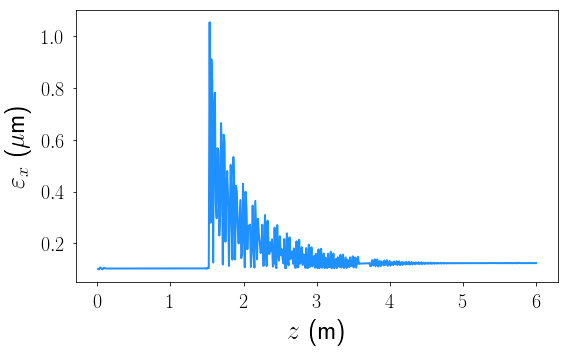

In [14]:
l1.plot('emitx')

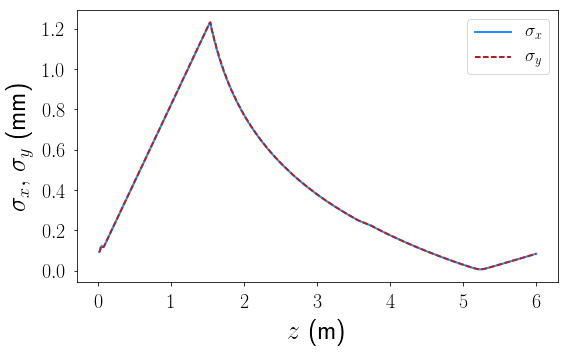

In [15]:
l1.plot(['Sx', 'Sy'])